In [1]:
import sys
from os.path import join, abspath
from glob import glob
import numpy as np
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
from scipy.stats import norm, skewnorm

In [2]:
# import utils
root_dir = abspath(join('..'))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/6_Analisis',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import style, hdi, load_spectral_types

In [5]:
sp = load_spectral_types()
sp

,SpT,M_J,J-H,H-Ks,J-K
0,O9V,-3.44,-0.164,-0.071,-0.235
1,O9.5V,-3.30,-0.161,-0.069,-0.230
2,B0V,-3.17,-0.159,-0.067,-0.226
3,B0.5V,-2.80,-0.153,-0.063,-0.216
4,B1V,-2.33,-0.148,-0.059,-0.207
...,...,...,...,...,...
95,T6V,15.34,0.100,-0.030,0.070
96,T7V,15.83,0.000,0.000,0.000
97,T7.5V,16.61,0.200,-0.050,0.150
98,T8V,17.30,0.200,-0.050,0.150


In [6]:
style(name="seaborn-notebook")

In [7]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [8]:
data_baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

(0.0, 1.0)

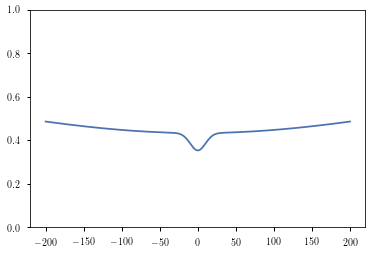

In [9]:
from scipy.stats import norm
def compz(z):
    a = -2*norm.pdf(z, loc=0, scale=10) -200*norm.pdf(z, loc=0, scale=300)
    return a+0.7

zz = np.linspace(-200, 200, 1000)

plt.plot(zz, compz(zz))
plt.ylim(0,1)


## thin

In [10]:
mcmc_dir = join(root_data_dir, "MCMC-mock", "thin", "dm", "data")
mcmc_dir

'/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/dm/data'

In [11]:
files = glob(join(mcmc_dir, "chain-*"))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/dm/data/chain-0001000.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/dm/data/chain-0010000.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/dm/data/chain-0100000.npy']

## tes

In [12]:
index = 0
df = np.load(files[index])
df.shape

(2500, 330, 33)

In [13]:
rhob = df[:, :, 12:24]
rhob = rhob.reshape(-1, 12)
rhob = rhob.sum(axis=1)/1E-2
rhoDM = df[:, :, 24].reshape(-1)/1E-2
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2

In [14]:
rhob0_sample = np.random.choice(rhob0, size=50_000, replace=False)
rhob0_fit = norm.fit(rhob0_sample)

rhob0 = 8.90 +0.70/-0.71


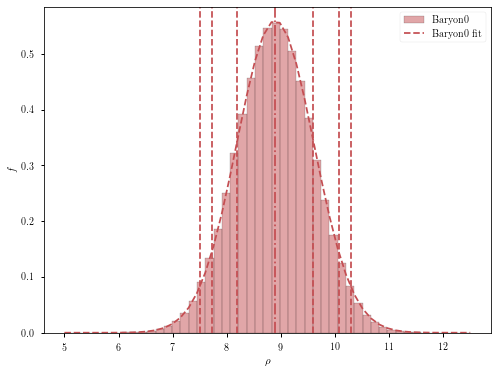

In [15]:
sigmas = np.array([68, 90, 95])
alpha = 1 - sigmas/100

rhob0_low = []
rhob0_high = []
rhob0_mode = rhob0_fit[0]
for i, alp in enumerate(alpha):
    hpd, modes = hdi(lambda x: norm.pdf(x, *rhob0_fit), low=5, high=12.5, alpha=alp)
    low, high = hpd[0]
    rhob0_low.append(low)
    rhob0_high.append(high)
# plot
rho = np.linspace(5, 12.5, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhob0_mode, color='C2', ls='-.')
for low, high in zip(rhob0_low, rhob0_high):
    ax.axvline(low, color='C2', ls='--')
    ax.axvline(high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

In [16]:
from tqdm import tqdm

rhoDM_modes_thin = []
rhoDM_errs_thin = []
rhob_modes_thin = []
rhob_errs_thin = []
rhoDM_fits_thin = []

for file in tqdm(files):
    df = np.load(file)
    rhob = df[:, :, 12:24]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df[:, :, 24].reshape(-1)/1E-2
    # print("fitting...")
    rhoDM_sample = np.random.choice(rhoDM, size=10_000, replace=False)
    rhoDM_fit = skewnorm.fit(rhoDM_sample)
    rhoDM_fits_thin.append(rhoDM_fit)
    rhob_sample = np.random.choice(rhob, size=10_000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)
    # print("calculating HDI...")
    rhoDM_err = []
    rhob_err = []
    rhoDM_mode = None
    rhob_mode = None
    for i, alp in enumerate(alpha):
        hpd, modes = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), -5, 10, alpha=alp)
        rhoDM_mode = modes[0]
        low, high = hpd[0]
        rhoDM_err.append({'alpha': alp, 'low': low, 'high': high})

        hpd, modes = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), 5, 15, alpha=alp)
        rhob_mode = modes[0]
        low, high = hpd[0]
        rhob_err.append({'alpha': alp, 'low': low, 'high': high})
    rhoDM_errs_thin.append(rhoDM_err)
    rhob_errs_thin.append(rhob_err)
    rhoDM_modes_thin.append(rhoDM_mode)
    rhob_modes_thin.append(rhob_mode)

100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


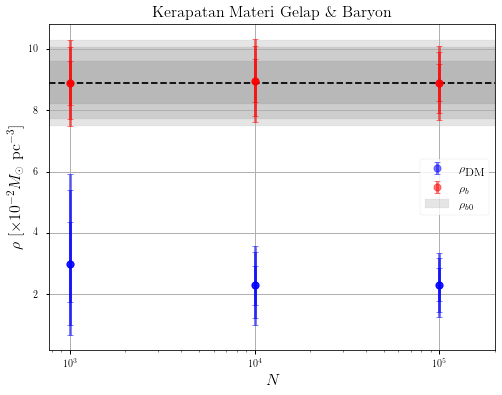

In [19]:
ns = [1000, 10000, 100000]
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
for i in range(3):
    low = np.array([err[i]['low'] for err in rhoDM_errs_thin])
    high = np.array([err[i]['high'] for err in rhoDM_errs_thin])
    dm_ax = ax.errorbar(ns, rhoDM_modes_thin, yerr=[rhoDM_modes_thin-low, high-rhoDM_modes_thin], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([err[i]['low'] for err in rhob_errs_thin])
    high = np.array([err[i]['high'] for err in rhob_errs_thin])
    rhob_ax = ax.errorbar(ns, rhob_modes_thin, yerr=[rhob_modes_thin-low, high-rhob_modes_thin], fmt='o', color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    rhob0 = ax.fill_between([0, 200000], [rhob0_low[i], rhob0_low[i]], [rhob0_high[i], rhob0_high[i]], color='black', alpha=0.1)
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob0], 
                  [r'$\rho_{\textup{DM}}$', r'$\rho_{b}$', r'$\rho_{b0}$'],
                  loc='best', fontsize=12)
# real value
ax.set_xlabel(r'$N$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_title("Kerapatan Materi Gelap \& Baryon", fontsize=16)
ax.grid()
ax.set_xscale('log')
ax.set_xlim(0, 200_000)
fig.savefig(join('img', 'rhoDM-mock-thin.pdf'), dpi=70)
plt.show()


In [18]:
rhoDM_errs_thin, rhoDM_modes_thin

([[{'alpha': 0.31999999999999995, 'low': 1.74, 'high': 4.37},
   {'alpha': 0.09999999999999998, 'low': 1.0, 'high': 5.4},
   {'alpha': 0.050000000000000044, 'low': 0.65, 'high': 5.93}],
  [{'alpha': 0.31999999999999995, 'low': 1.63, 'high': 2.93},
   {'alpha': 0.09999999999999998, 'low': 1.21, 'high': 3.36},
   {'alpha': 0.050000000000000044, 'low': 1.0, 'high': 3.57}],
  [{'alpha': 0.31999999999999995, 'low': 1.78, 'high': 2.84},
   {'alpha': 0.09999999999999998, 'low': 1.42, 'high': 3.19},
   {'alpha': 0.050000000000000044, 'low': 1.25, 'high': 3.35}]],
 [2.97, 2.29, 2.31])

## thick

In [20]:
mcmc_dir = join(root_data_dir, "MCMC-mock", "thic", "dm", "data")
mcmc_dir

'/home2/s20321005/Thesis-Project/Data/MCMC-mock/thic/dm/data'

In [21]:
files = glob(join(mcmc_dir, "chain-*"))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/MCMC-mock/thic/dm/data/chain-0001000.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thic/dm/data/chain-0010000.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thic/dm/data/chain-0100000.npy']

In [22]:
index = 0
df = np.load(files[index])
df.shape

(2500, 330, 33)

In [23]:
rhob = df[:, :, 12:24]
rhob = rhob.reshape(-1, 12)
rhob = rhob.sum(axis=1)/1E-2
rhoDM = df[:, :, 24].reshape(-1)/1E-2
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2

In [24]:
rhob0_sample = np.random.choice(rhob0, size=50_000, replace=False)
rhob0_fit = norm.fit(rhob0_sample)

rhob0 = 8.90 +0.70/-0.71


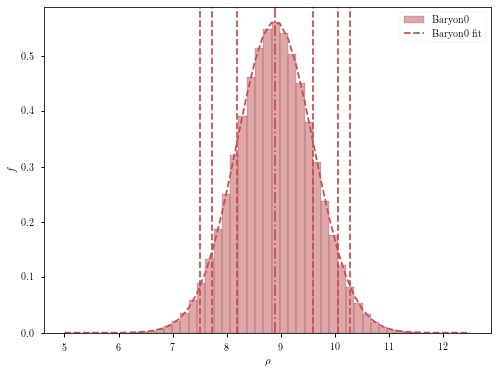

In [25]:
rhob0_low = []
rhob0_high = []
for i, alp in enumerate(alpha):
    hpd, modes = hdi(lambda x: norm.pdf(x, *rhob0_fit), low=5, high=12.5, alpha=alp)
    low, high = hpd[0]
    rhob0_low.append(low)
    rhob0_high.append(high)
# plot
rho = np.linspace(5, 12.5, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhob0_mode, color='C2', ls='-.')
for low, high in zip(rhob0_low, rhob0_high):
    ax.axvline(low, color='C2', ls='--')
    ax.axvline(high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

In [26]:
from tqdm import tqdm

rhoDM_modes_thic = []
rhoDM_errs_thic = []
rhob_modes_thic = []
rhob_errs_thic = []
rhoDM_fits_thic = []

for file in tqdm(files):
    df = np.load(file)
    rhob = df[:, :, 12:24]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rhoDM = df[:, :, 24].reshape(-1)/1E-2
    # print("fitting...")
    rhoDM_sample = np.random.choice(rhoDM, size=10_000, replace=False)
    rhoDM_fit = skewnorm.fit(rhoDM_sample)
    rhoDM_fits_thic.append(rhoDM_fit)
    rhob_sample = np.random.choice(rhob, size=10_000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)
    # print("calculating HDI...")
    rhoDM_err = []
    rhob_err = []
    rhoDM_mode = None
    rhob_mode = None
    for i, alp in enumerate(alpha):
        hpd, modes = hdi(lambda x: skewnorm.pdf(x, *rhoDM_fit), -5, 10, alpha=alp)
        rhoDM_mode = modes[0]
        low, high = hpd[0]
        rhoDM_err.append({'alpha': alp, 'low': low, 'high': high})

        hpd, modes = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), 5, 15, alpha=alp)
        rhob_mode = modes[0]
        low, high = hpd[0]
        rhob_err.append({'alpha': alp, 'low': low, 'high': high})
    rhoDM_errs_thic.append(rhoDM_err)
    rhob_errs_thic.append(rhob_err)
    rhoDM_modes_thic.append(rhoDM_mode)
    rhob_modes_thic.append(rhob_mode)

100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


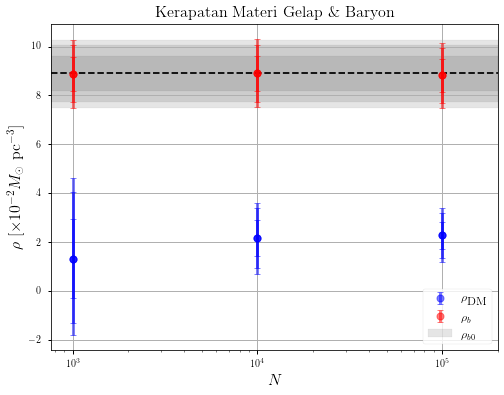

In [27]:
ns = [1000, 10000, 100000]
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
for i in range(3):
    low = np.array([err[i]['low'] for err in rhoDM_errs_thic])
    high = np.array([err[i]['high'] for err in rhoDM_errs_thic])
    dm_ax = ax.errorbar(ns, rhoDM_modes_thic, yerr=[rhoDM_modes_thic-low, high-rhoDM_modes_thic], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([err[i]['low'] for err in rhob_errs_thic])
    high = np.array([err[i]['high'] for err in rhob_errs_thic])
    rhob_ax = ax.errorbar(ns, rhob_modes_thic, yerr=[rhob_modes_thic-low, high-rhob_modes_thic], fmt='o', color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    rhob0 = ax.fill_between([0, 200000], [rhob0_low[i], rhob0_low[i]], [rhob0_high[i], rhob0_high[i]], color='black', alpha=0.1)
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob0], 
                  [r'$\rho_{\textup{DM}}$', r'$\rho_{b}$', r'$\rho_{b0}$'],
                  loc='best', fontsize=12)
# real value
ax.set_xlabel(r'$N$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_title("Kerapatan Materi Gelap \& Baryon", fontsize=16)
ax.grid()
ax.set_xscale('log')
ax.set_xlim(0, 200_000)
fig.savefig(join('img', 'rhoDM-mock-thic.pdf'), dpi=70)
plt.show()


In [28]:
rhoDM_errs_thic, rhoDM_modes_thic

([[{'alpha': 0.31999999999999995, 'low': -0.31, 'high': 2.95},
   {'alpha': 0.09999999999999998, 'low': -1.34, 'high': 4.06},
   {'alpha': 0.050000000000000044, 'low': -1.83, 'high': 4.6}],
  [{'alpha': 0.31999999999999995, 'low': 1.42, 'high': 2.89},
   {'alpha': 0.09999999999999998, 'low': 0.94, 'high': 3.37},
   {'alpha': 0.050000000000000044, 'low': 0.7, 'high': 3.61}],
  [{'alpha': 0.31999999999999995, 'low': 1.72, 'high': 2.83},
   {'alpha': 0.09999999999999998, 'low': 1.35, 'high': 3.2},
   {'alpha': 0.050000000000000044, 'low': 1.17, 'high': 3.37}]],
 [1.29, 2.16, 2.27])